# 機械学習モデルのチューニング
## グリッドサーチでチューニング

In [10]:
#  坂井さんの分のコードでimportされてるやつをしておかないと死ぬ
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                 header=None)
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

#以下今回のコード

#  grid_searchを使うと古いでって怒られる
#  from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# パイプラインを定義
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

# パラメータに試す値のリスト
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# 線形SVMとRBFカーネルSVMを試す
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


グリッドサーチで選択されたモデルの妥当性を、
トレーニングサブセットとは独立したテストセットで確認する

In [11]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


## 入れ子の交差検証

In [14]:
# 足りないimport問題
import numpy as np
from sklearn.cross_validation import cross_val_score

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy',
   cv=5)
print('CV accuracy: %.3f +/- %.3f' % (
    np.mean(scores), np.std(scores)))


CV accuracy: 0.965 +/- 0.025


# 性能評価指標
## 混合行列

In [15]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


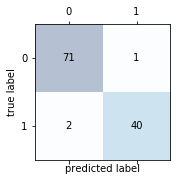

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [ ]:
PREとRECとF1

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics  import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


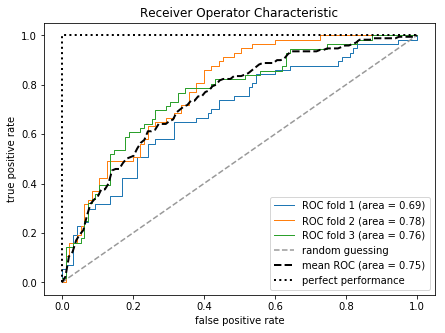

In [23]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import roc_curve, auc
from scipy import interp
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2',
                                               random_state = 0,
                                               C=100.0))])
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train,
                     n_folds=3,
                     random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
             % (i+1, roc_auc))
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

AUCと正解率だけ取る

In [24]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(
    y_true=y_test, y_score=y_pred2))

print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711
